### Step 1: Define a function to load and clean datasets ###

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def load_and_clean_dataset(filepath):
    """Load the dataset from the given file path, clean missing values, and convert to numeric."""
    columns = [
        "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
        "exang", "oldpeak", "slope", "ca", "thal", "target"
    ]
    df = pd.read_csv(filepath, header=None, names=columns)
    print(f"Loaded dataset from {filepath}, with {len(df)} rows before cleaning.")
    df.replace('?', pd.NA, inplace=True)
    df.dropna(inplace=True)
    print(f"Dataset from {filepath} cleaned. Rows remaining: {len(df)}")
    return df.apply(pd.to_numeric)

### Step 2: Import datasets ###

In [2]:
cleveland_path = "processed.cleveland.data"
hungarian_path = "processed.hungarian.data"
switzerland_path = "processed.switzerland.data"

### Step 3: Load datasets ###

In [3]:
print("Loading datasets...")
cleveland_data = load_and_clean_dataset(cleveland_path)
hungarian_data = load_and_clean_dataset(hungarian_path)
switzerland_data = load_and_clean_dataset(switzerland_path)

Loading datasets...
Loaded dataset from processed.cleveland.data, with 303 rows before cleaning.
Dataset from processed.cleveland.data cleaned. Rows remaining: 297
Loaded dataset from processed.hungarian.data, with 294 rows before cleaning.
Dataset from processed.hungarian.data cleaned. Rows remaining: 1
Loaded dataset from processed.switzerland.data, with 123 rows before cleaning.
Dataset from processed.switzerland.data cleaned. Rows remaining: 0


### Step 4: Combine the datasets ###

In [4]:
print("Combining datasets...")
data = pd.concat([cleveland_data, hungarian_data, switzerland_data], ignore_index=True)
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)
print(f"Combined dataset has {len(data)} rows.")

Combining datasets...
Combined dataset has 298 rows.


/tmp/ipykernel_755/3636221008.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([cleveland_data, hungarian_data, switzerland_data], ignore_index=True)


### Step 5: Define features and target variables ###

In [5]:
print("Defining features and target variables...")
X = data.drop(columns=['target'])
y = data['target']

Defining features and target variables...


### Step 6: Define train-test partitions and trials ###

In [6]:
partitions = [0.8, 0.5, 0.2]  # Train-test ratios
num_trials = 3
results = []

### Step 7: Train and evaluate models for each partition ###

In [7]:
for partition in partitions:
    print(f"\nProcessing partition: {int(partition*100)}/{int((1-partition)*100)}")

    partition_results = []
    for trial in range(num_trials):
        print(f"Trial {trial + 1}")

        # Step 7.1: Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-partition, random_state=trial)

        # Step 7.2: Train and evaluate SVM
        print("\nTraining Support Vector Machine (SVM)...")
        svm = SVC(kernel='linear')
        svm_params = {'C': [0.1, 1, 10]}
        svm_cv = GridSearchCV(svm, svm_params, cv=3, scoring='accuracy')
        svm_cv.fit(X_train, y_train)
        svm_pred = svm_cv.predict(X_test)
        svm_accuracy = accuracy_score(y_test, svm_pred)
        print("SVM Classification Report:")
        print(classification_report(y_test, svm_pred))
        print(f"Best parameters for SVM: {svm_cv.best_params_}")

        # Step 7.3: Train and evaluate Random Forest
        print("\nTraining Random Forest...")
        rf = RandomForestClassifier(random_state=42)
        rf_params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, None]}
        rf_cv = GridSearchCV(rf, rf_params, cv=3, scoring='accuracy')
        rf_cv.fit(X_train, y_train)
        rf_pred = rf_cv.predict(X_test)
        rf_accuracy = accuracy_score(y_test, rf_pred)
        print("Random Forest Classification Report:")
        print(classification_report(y_test, rf_pred))
        print(f"Best parameters for Random Forest: {rf_cv.best_params_}")

        # Step 7.4: Train and evaluate Decision Tree
        print("\nTraining Decision Tree...")
        dt = DecisionTreeClassifier(random_state=42)
        dt_params = {'max_depth': [5, 10, None]}
        dt_cv = GridSearchCV(dt, dt_params, cv=3, scoring='accuracy')
        dt_cv.fit(X_train, y_train)
        dt_pred = dt_cv.predict(X_test)
        dt_accuracy = accuracy_score(y_test, dt_pred)
        print("Decision Tree Classification Report:")
        print(classification_report(y_test, dt_pred))
        print(f"Best parameters for Decision Tree: {dt_cv.best_params_}")

        # Store results for this trial
        partition_results.append({
            'Trial': trial + 1,
            'Partition': f'{int(partition*100)}/{int((1-partition)*100)}',
            'SVM Accuracy': svm_accuracy,
            'Random Forest Accuracy': rf_accuracy,
            'Decision Tree Accuracy': dt_accuracy
        })

    # Average results across trials
    avg_results = {
        'Partition': f'{int(partition*100)}/{int((1-partition)*100)}',
        'SVM Accuracy': np.mean([r['SVM Accuracy'] for r in partition_results]),
        'Random Forest Accuracy': np.mean([r['Random Forest Accuracy'] for r in partition_results]),
        'Decision Tree Accuracy': np.mean([r['Decision Tree Accuracy'] for r in partition_results])
    }
    results.append(avg_results)


Processing partition: 80/19
Trial 1

Training Support Vector Machine (SVM)...
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87        28
           1       0.96      0.78      0.86        32

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60

Best parameters for SVM: {'C': 1}

Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        28
           1       0.96      0.81      0.88        32

    accuracy                           0.88        60
   macro avg       0.89      0.89      0.88        60
weighted avg       0.90      0.88      0.88        60

Best parameters for Random Forest: {'max_depth': 5, 'n_estimators': 100}

Training Decision Tree...
Decision Tree Classification Report:
     

### Step 8: Display results ###

In [8]:
print("\nFinal Results:")
results_df = pd.DataFrame(results)
print(results_df)


Final Results:
  Partition  SVM Accuracy  Random Forest Accuracy  Decision Tree Accuracy
0     80/19      0.833333                0.855556                0.738889
1     50/50      0.825503                0.859060                0.762864
2     20/80      0.781032                0.806137                0.682008


### Step 9: Visualize results ###


Visualizing results...


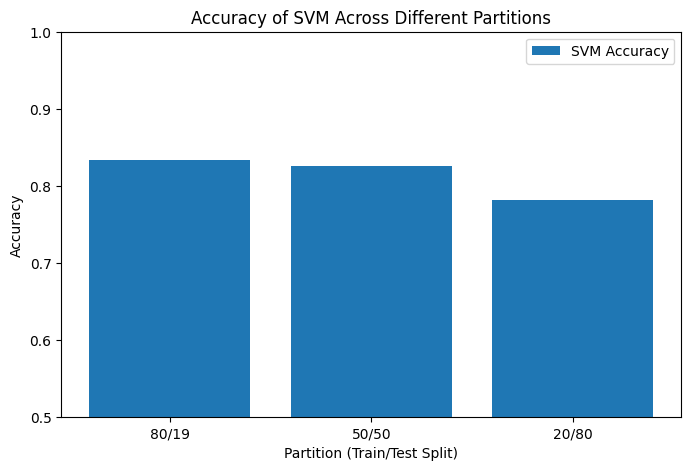

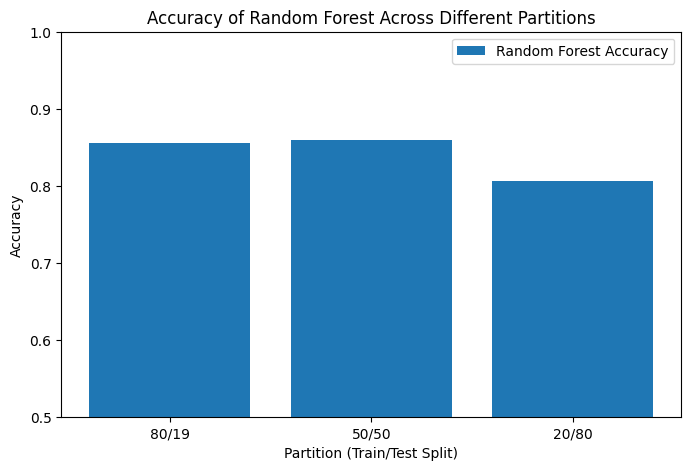

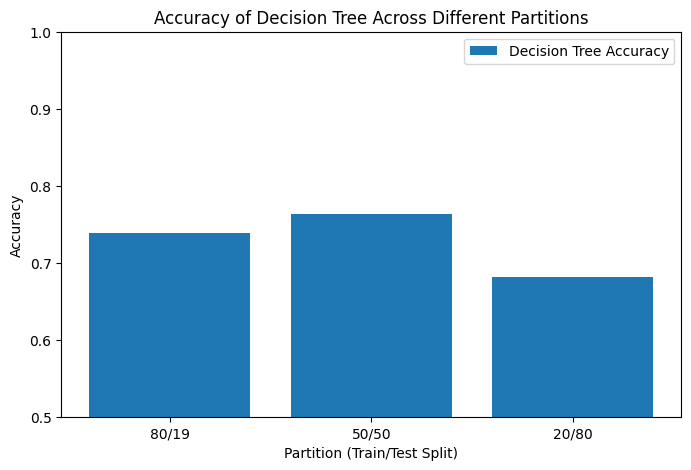


Process completed.


In [9]:
print("\nVisualizing results...")
models = ['SVM', 'Random Forest', 'Decision Tree']
for model in models:
    plt.figure(figsize=(8, 5))
    plt.bar(results_df['Partition'], results_df[f'{model} Accuracy'], label=f'{model} Accuracy')
    plt.ylim(0.5, 1)
    plt.title(f'Accuracy of {model} Across Different Partitions')
    plt.xlabel('Partition (Train/Test Split)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

print("\nProcess completed.")